In [1]:
import re
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches


from Utilities.EvaluationMain import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects, LoadModelConfigs, LoadParams
from Models.Caller import *
from Utilities.Visualization import VisReconGivenZ_FCA, HeatMapFreqZ_FCA, VisReconGivenFC_ZA, VisReconExtractZ_FC


from Benchmarks.Models.BenchmarkCaller import ModelCall as BMCaller
from Utilities.Visualization import *

In [2]:
SelIDX= 1
N_Gen = 500
MinFreqR=0.0
MaxFreqR=0.99


YamlPath =  './Benchmarks/Config/EvalConfigII.yml' 
#YamlPath = './Config/EvalConfigART800.yml'
ConfigName = 'ConVAE_II_50' #'SKZFC_ART_50_800' #'BaseVAE_ART_50' #'ConVAE_ART_50'


if 'ConVAE' in ConfigName:
    ModelType = 'ConVAE'
elif 'BaseVAE' in ConfigName:
    ModelType = 'BaseVAE'
elif 'SKZFC' in ConfigName or 'FACFC' in ConfigName or 'TCMIDKZFC' in ConfigName or 'SKZ' in ConfigName:
    ModelType = 'Ours'

EvalConfigs = ReadYaml(YamlPath)
ModelConfigs = ReadYaml(YamlPath)

# Loading the model configurations
if ModelType == 'BaseVAE' or ModelType == 'ConVAE':
    ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName, Comp=False, RootDirYaml='./Benchmarks/Config/')
else:
    ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName)

# Loading parameters for the evaluation
Params = LoadParams(ModelConfigSet, EvalConfigs[ConfigName])
Params['Common_Info'] = EvalConfigs['Common_Info']


# Loading data
TrData = np.load('./Data/ProcessedData/Tr'+str(Params['SigType'])+'.npy').astype('float32')
VallData = np.load('./Data/ProcessedData/Val'+str(Params['SigType'])+'.npy').astype('float32')

# Intermediate parameters 
SigDim = VallData.shape[1]
DataSize = VallData.shape[0]

In [3]:
if ModelType == 'Ours':
    
    # Calling Modesl
    SigRepModel, ModelParts = ModelCall (ModelConfigSet, SigDim, DataSize, LoadWeight=True, ReturnModelPart=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadName)
    
    # Setting Model Specifications and Sub-models
    if Params['LossType'] =='Default':
        EncModel, FeatExtModel, FeatGenModel, ReconModel = ModelParts
    elif Params['LossType'] =='FACLosses':
        EncModel, FeatExtModel, FeatGenModel, ReconModel, FacDiscModel = ModelParts
        
    ## The generation model for evaluation
    RecOut = ReconModel(FeatGenModel.output)
    GenModel = Model(FeatGenModel.input, RecOut)
    
    ## The sampling model for evaluation
    Zs_Out = SigRepModel.get_layer('Zs').output
    SampModel = Model(EncModel.input, Zs_Out)

    # Signal generation
    AnalData = VallData
    InpSignal = np.repeat(AnalData[SelIDX:SelIDX+1], N_Gen, axis=0)
    PredZs = SampModel.predict(InpSignal)
    
    FC_Comm = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,2))
    FC_Each = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,4))
    
    FeatGen = FeatGenModel([FC_Comm,FC_Each, PredZs])
    ReconSignal = ReconModel([FeatGen])
    

elif ModelType == 'BaseVAE':

    # Calling Modesl
    BenchModel, _, AnalData = BMCaller (ModelConfigSet, ConfigName, TrData, VallData, LoadWeight=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName='./Benchmarks/' + ModelLoadName[2:]) 
    
    ## The generation model for evaluation
    GenModel = BenchModel.get_layer('ReconModel')
    
    ## The sampling model for evaluation
    Inp_Enc = BenchModel.get_layer('Inp_Enc')
    Zs = BenchModel.get_layer('Zs').output
    
    if Params['SecDataType'] == 'CONDIN':
        Inp_Cond = BenchModel.get_layer('Inp_Cond')
        SampModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)
    else:
        SampModel = Model(Inp_Enc.input, Zs)

    # Signal generation
    InpSignal = np.repeat(VallData[SelIDX:SelIDX+1], N_Gen, axis=0)
    PredZs = SampModel.predict(InpSignal)
    
    VariZs = PredZs  + np.sort(np.random.normal(0, Params['ReparaStd'], N_Gen))[:,None]
    ReconSignal = GenModel.predict(VariZs)


elif ModelType == 'ConVAE':
    
    # Calling Modesl
    BenchModel, _, AnalData = BMCaller (ModelConfigSet, ConfigName, TrData, VallData, LoadWeight=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName='./Benchmarks/' + ModelLoadName[2:]) 
            
    ## The generation model for evaluation
    GenModel = BenchModel.get_layer('ReconModel')
    
    ## The sampling model for evaluation
    Inp_Enc = BenchModel.get_layer('Inp_Enc')
    Zs = BenchModel.get_layer('Zs').output
    
    if Params['SecDataType'] == 'CONDIN':
        Inp_Cond = BenchModel.get_layer('Inp_Cond')
        SampModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)
    else:
        SampModel = Model(Inp_Enc.input, Zs)

    # Signal generation
    RawSignal, ConData = AnalData
    CON_Arange = GenConArangeSimple(ConData, N_Gen)
    InpSignal = np.repeat(RawSignal[SelIDX:SelIDX+1], N_Gen, axis=0)
    PredZs = SampModel.predict([InpSignal, CON_Arange])
    ReconSignal = GenModel([PredZs, CON_Arange])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame (TFOpLambda)   (None, 20, 50)       0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 50)       11550       ['tf.signal.frame[0][0]']        
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20, 50)      11550       ['bidirectional[0][0]']          
 )                                                                                            

In [68]:
def CustomLinspace(start, end, breakpoints, numbers):
    """
    Generate a series of points within specified intervals and number of points.

    Parameters:
    start (float): The starting value of the sequence.
    end (float): The end value of the sequence.
    breakpoints (list): A list of points where the intervals change.
    numbers (list): A list of integers indicating the number of points in each interval.

    Returns:
    np.array: An array of points including the start, end, and the specified number of points in each interval.
    """

    # Validate input: there should be one more number than there are breakpoints
    if len(breakpoints) + 1 != len(numbers):
        raise ValueError("There must be one more element in 'numbers' than there are in 'breakpoints'.")

    # Combine the start, breakpoints, and end into a single list of points
    points = [start] + breakpoints + [end]
    
    # Initialize an empty array to hold the result
    result = np.array([])

    # Generate points for each interval
    for i in range(len(numbers)):
        # Determine if the endpoint should be included
        endpoint = True if i == len(numbers) - 1 else False  # Include endpoint only for the last interval
        
        # Generate 'numbers[i]' points between 'points[i]' and 'points[i + 1]'
        part = np.linspace(points[i], points[i + 1], numbers[i], endpoint=endpoint)
        result = np.concatenate((result, part))  # Append the new points to the result

    return result


def SigGen (ConfigName, YamlPath, SelIDX= 1, N_Gen = 300, MinFreqR=0.0, MaxFreqR=0.05, GenBP=None, N_GenList = None):
    
    if N_GenList is not None:
            N_Gen = np.sum(N_GenList)
        
    if 'ConVAE' in ConfigName:
        ModelType = 'ConVAE'
    elif 'BaseVAE' in ConfigName or 'TCVAE' in ConfigName or 'FACVAE' in ConfigName:
        ModelType = 'BaseVAE'
    elif 'SKZFC' in ConfigName or 'FACFC' in ConfigName or 'TCMIDKZFC' in ConfigName or 'SKZ' in ConfigName:
        ModelType = 'Ours'
    
    EvalConfigs = ReadYaml(YamlPath)
    ModelConfigs = ReadYaml(YamlPath)
    
    # Loading the model configurations
    if ModelType == 'BaseVAE' or ModelType == 'ConVAE':
        ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName, Comp=False, RootDirYaml='./Benchmarks/Config/')
    else:
        ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName)
    
    # Loading parameters for the evaluation
    Params = LoadParams(ModelConfigSet, EvalConfigs[ConfigName])
    Params['Common_Info'] = EvalConfigs['Common_Info']
    
    
    # Loading data
    TrData = np.load('./Data/ProcessedData/Tr'+str(Params['SigType'])+'.npy').astype('float32')
    VallData = np.load('./Data/ProcessedData/Val'+str(Params['SigType'])+'.npy').astype('float32')
    
    # Intermediate parameters 
    SigDim = VallData.shape[1]
    DataSize = VallData.shape[0]


    if ModelType == 'Ours':

        if N_GenList is not None:
            FC_Comm = np.tile(CustomLinspace(MinFreqR, MaxFreqR, GenBP, N_GenList)[:, None], (1,2))
            FC_Each = np.tile(CustomLinspace(MinFreqR, MaxFreqR, GenBP, N_GenList)[:, None], (1,4))
        else:
            FC_Comm = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,2))
            FC_Each = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,4))
            
    
        # Calling Modesl
        SigRepModel, ModelParts = ModelCall (ModelConfigSet, SigDim, DataSize, LoadWeight=True, ReturnModelPart=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadName)
        
        # Setting Model Specifications and Sub-models
        if Params['LossType'] =='Default':
            EncModel, FeatExtModel, FeatGenModel, ReconModel = ModelParts
        elif Params['LossType'] =='FACLosses':
            EncModel, FeatExtModel, FeatGenModel, ReconModel, FacDiscModel = ModelParts
            
        ## The generation model for evaluation
        RecOut = ReconModel(FeatGenModel.output)
        GenModel = Model(FeatGenModel.input, RecOut)
        
        ## The sampling model for evaluation
        Zs_Out = SigRepModel.get_layer('Zs').output
        SampModel = Model(EncModel.input, Zs_Out)
    
        # Signal generation
        AnalData = VallData
        OrginalSig = AnalData[SelIDX:SelIDX+1]
        InpSignal = np.repeat(OrginalSig, N_Gen, axis=0)
        PredZs = SampModel.predict(InpSignal)

        FeatGen = FeatGenModel([FC_Comm,FC_Each, PredZs])
        ReconSignal = ReconModel.predict([FeatGen])
        CON_Arange = None
        
    
    elif ModelType == 'BaseVAE':
    
        # Calling Modesl
        BenchModel, _, AnalData = BMCaller (ModelConfigSet, ConfigName, TrData, VallData, LoadWeight=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName='./Benchmarks/' + ModelLoadName[2:]) 
        
        ## The generation model for evaluation
        GenModel = BenchModel.get_layer('ReconModel')
        
        ## The sampling model for evaluation
        Inp_Enc = BenchModel.get_layer('Inp_Enc')
        Zs = BenchModel.get_layer('Zs').output
        
        if Params['SecDataType'] == 'CONDIN':
            Inp_Cond = BenchModel.get_layer('Inp_Cond')
            SampModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)
        else:
            SampModel = Model(Inp_Enc.input, Zs)
    
        # Gignal generation
        OrginalSig = AnalData[SelIDX:SelIDX+1]
        InpSignal = np.repeat(OrginalSig, N_Gen, axis=0)
        PredZs = SampModel.predict(InpSignal)
        
        PredZs = PredZs  + np.sort(np.random.normal(0, Params['ReparaStd'], N_Gen))[:,None]
        ReconSignal = GenModel.predict(PredZs)
        CON_Arange = None
    
    
    elif ModelType == 'ConVAE':
        
        # Calling Modesl
        BenchModel, _, AnalData = BMCaller (ModelConfigSet, ConfigName, TrData, VallData, LoadWeight=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName='./Benchmarks/' + ModelLoadName[2:]) 
                
        ## The generation model for evaluation
        GenModel = BenchModel.get_layer('ReconModel')
        
        ## The sampling model for evaluation
        Inp_Enc = BenchModel.get_layer('Inp_Enc')
        Zs = BenchModel.get_layer('Zs').output
        
        if Params['SecDataType'] == 'CONDIN':
            Inp_Cond = BenchModel.get_layer('Inp_Cond')
            SampModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)
        else:
            SampModel = Model(Inp_Enc.input, Zs)
    
        # Signal generation
        RawSignal, ConData = AnalData
        CON_Arange = GenConArangeSimple(ConData, N_Gen)
        '''
        RandSelIDXbdm = np.random.randint(0, ConData.shape[0], N_Gen)
        SelConData = ConData[RandSelIDXbdm]
        CON_Arange = np.sort(SelConData, axis=0)
        '''
        #np.random.seed(0)
        #ConData = np.random.permutation(ConData)[:N_Gen]
        #CON_Arange = np.sort(ConData, axis=0)
        
        OrginalSig = RawSignal[SelIDX:SelIDX+1]
        InpSignal = np.repeat(OrginalSig, N_Gen, axis=0)
        PredZs = SampModel.predict([InpSignal, CON_Arange])
        ReconSignal = GenModel.predict([PredZs, CON_Arange])

    HalfLen = ReconSignal.shape[1]//2
    FFTRes = np.abs(np.fft.fft(ReconSignal, axis=-1)[:, :HalfLen]) 
    Amplitude = FFTRes/HalfLen

    return ReconSignal, Amplitude, OrginalSig, PredZs, CON_Arange
    
        

In [69]:
GenBP=[0.1, 0.5]
N_GenList = [300, 150, 50]

DicConfigYaml = {'SKZFC_ART_50_800': './Config/EvalConfigART800.yml',
                 'ConVAE_ART_50'  : './Benchmarks/Config/EvalConfigART.yml',
                 'BaseVAE_ART_50' : './Benchmarks/Config/EvalConfigART.yml',
                'SKZFC_II_50_800': './Config/EvalConfigII800.yml',
                 'ConVAE_II_50'  : './Benchmarks/Config/EvalConfigII.yml',
                 'BaseVAE_II_50' : './Benchmarks/Config/EvalConfigII.yml', 
                 'TCVAE_ART_50'         : './Benchmarks/Config/EvalConfigART.yml',
                 'FACVAE_ART_50'        : './Benchmarks/Config/EvalConfigART.yml',
                 'TCMIDKZFC_ART_50_800' : './Config/EvalConfigART800.yml',
                 'FACFC_ART_50_800'     : './Config/EvalConfigART800.yml',
                 'TCVAE_II_50'         : './Benchmarks/Config/EvalConfigII.yml',
                 'FACVAE_II_50'        : './Benchmarks/Config/EvalConfigII.yml',
                 'TCMIDKZFC_II_50_800' : './Config/EvalConfigII800.yml',
                 'FACFC_II_50_800'     : './Config/EvalConfigII800.yml'}

#DicConfigYaml = {'TCMIDKZFC_ART_50_800_A' : './Config/EvalConfigART800.yml'}



GeneratedSignals = {}
GeneratedAmplitude = {}
InpSignals = {}
Zs = {}
CON_Aranges = {}

for ConfigYaml in DicConfigYaml.items():
    print(ConfigYaml[0])
    #ReconSignal, Amplitude, InpSignal, PredZs, CON_Arange = SigGen(ConfigYaml[0], ConfigYaml[1], SelIDX= 1100, N_Gen = np.sum(N_GenList), MinFreqR=0.0, MaxFreqR=0.05,  GenBP=GenBP, N_GenList=N_GenList)
    ReconSignal, Amplitude, InpSignal, PredZs, CON_Arange = SigGen(ConfigYaml[0], ConfigYaml[1], SelIDX= 1100, N_Gen = 500, MinFreqR=0.0, MaxFreqR=0.05,  GenBP=GenBP)
    GeneratedSignals[ConfigYaml[0]] = ReconSignal
    GeneratedAmplitude[ConfigYaml[0]] = Amplitude
    InpSignals[ConfigYaml[0]] = InpSignal
    Zs[ConfigYaml[0]] = PredZs
    CON_Aranges[ConfigYaml[0]] = CON_Arange

SKZFC_ART_50_800
OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model_240"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_351 (TFOpLambd  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
 a)                                                                                               
                                                                                                  
 bidirectional_1098 (Bidirectio  (None, 20, 50)      11550       ['tf.signal.frame_351[0][0]']    
 nal)                                                                             

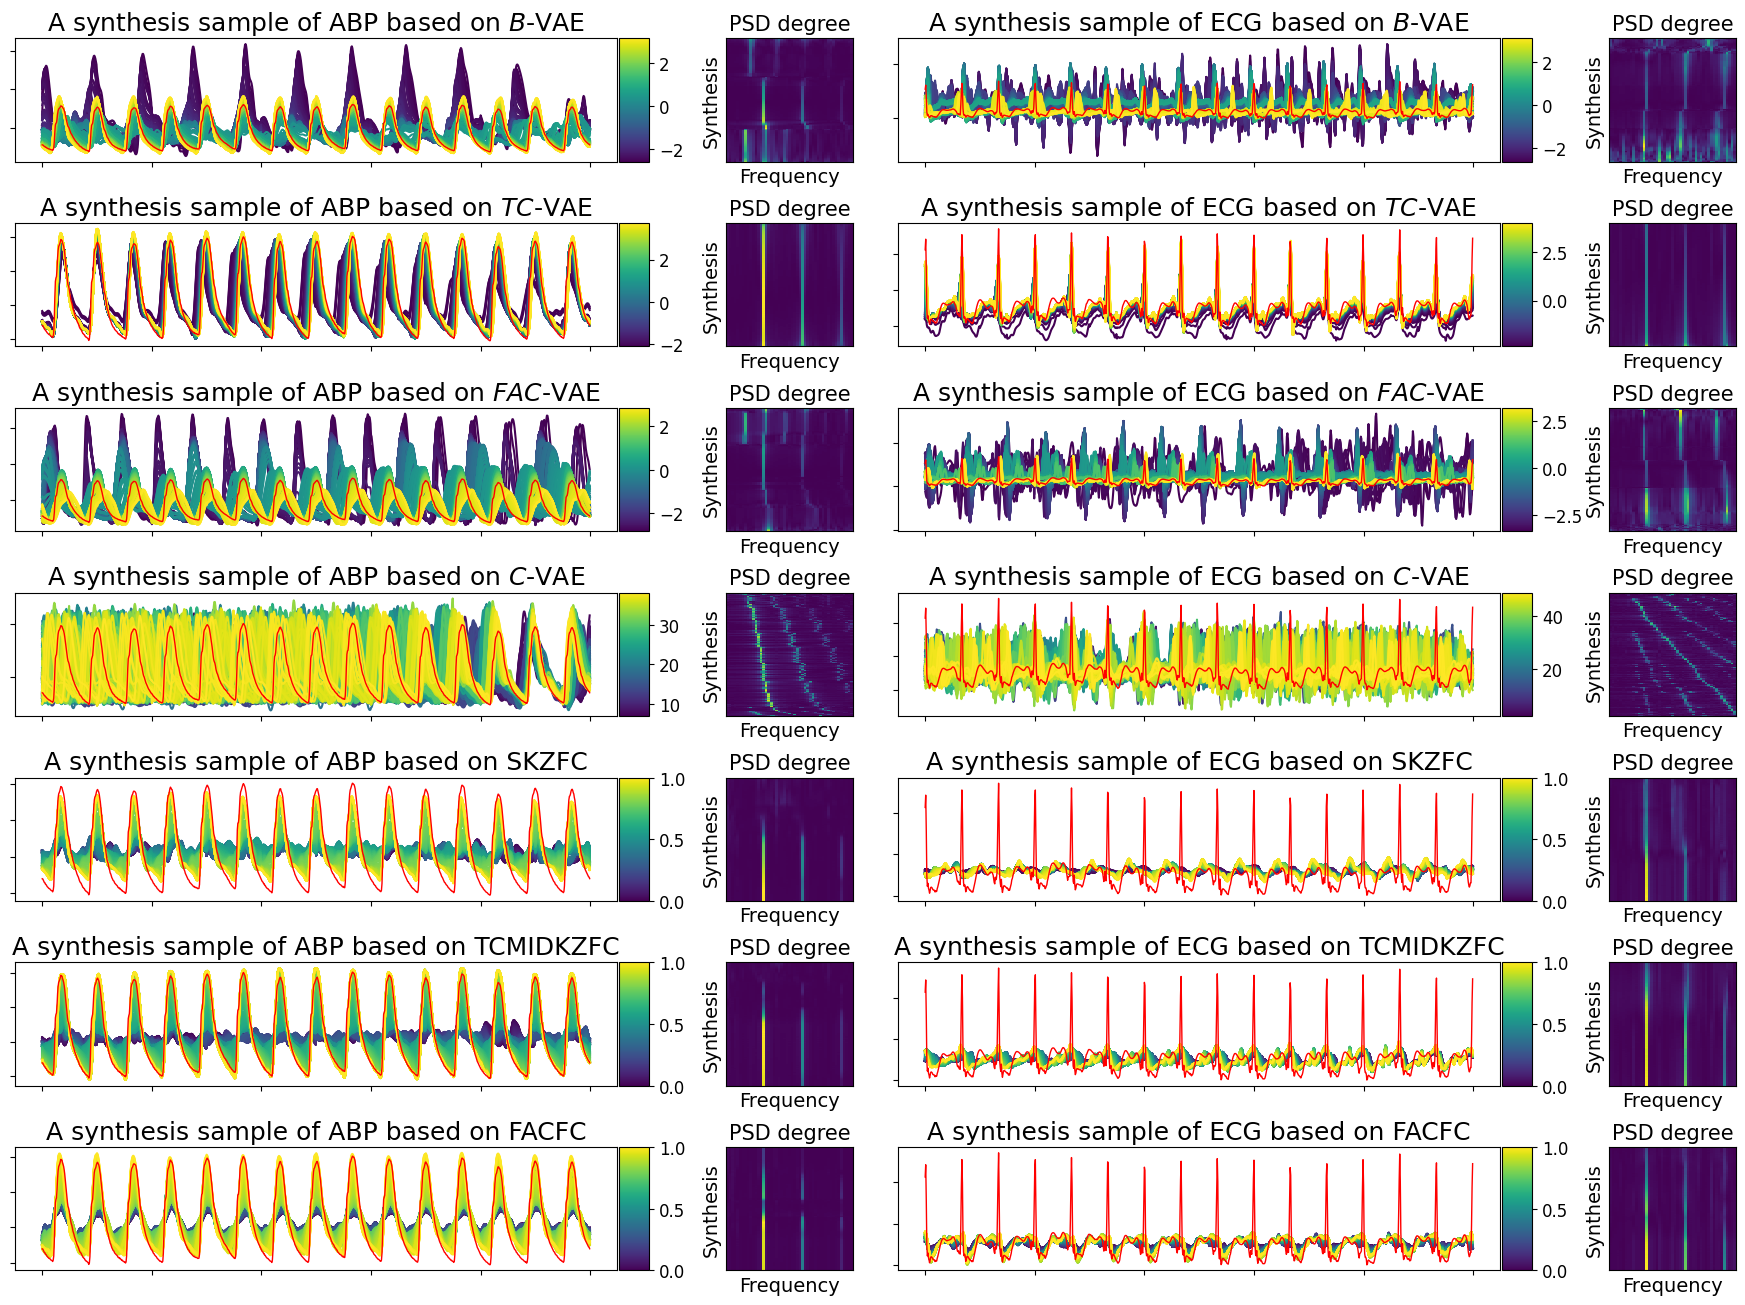

In [70]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

MinFreq=1
MaxFreq=50
MinFreqR = 0
MaxFreqR = 1.

# Define the keys for the data you want to plot.
keys = ['BaseVAE_ART_50', 'TCVAE_ART_50', 'FACVAE_ART_50', 'ConVAE_ART_50', 'SKZFC_ART_50_800', 'TCMIDKZFC_ART_50_800', 'FACFC_ART_50_800',  
         'BaseVAE_II_50', 'TCVAE_II_50',  'FACVAE_II_50',  'ConVAE_II_50',  'SKZFC_II_50_800',  'TCMIDKZFC_II_50_800',  'FACFC_II_50_800']

# Set up colormap and normalization.
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, N_Gen-1)


# Create a figure with GridSpec layout for a 3x2 grid of line plots and heatmaps.
fig = plt.figure(figsize=(22, 16))
gs = GridSpec(7, 4, figure=fig, width_ratios=[5, 1, 5, 1], hspace=0.5, wspace=0.16)  # Allocate space for color bars

row_idx = -1
col_idx_line = 0
col_idx_heat = 1

# Iterate over the keys and create the corresponding subplots for line plots and heatmaps.
for idx, key in enumerate(keys):
    # Calculate row index for the current subplot.
    row_idx += 1
    col_idx_heat = col_idx_line+1

    if 'SKZFC' in key or 'FACFC' in key or 'TCMIDKZFC' in key or 'SKZ' in key:
        norm2 = plt.Normalize(MinFreqR, MaxFreqR)
        cbarLabel = '$\\acute{\\theta}$ for generation'
    elif 'BaseVAE'in key or 'TCVAE' in key or 'FACVAE' in key:
        MeanZs = np.mean(Zs[key], axis=1)
        norm2 = plt.Normalize(min(MeanZs), max(MeanZs))
        cbarLabel = 'Mean of z for generation'
    elif 'ConVAE'in key:
        FreqIDX = np.argmax(CON_Aranges[key], axis=-1)
        norm2 = plt.Normalize(np.min(FreqIDX), np.max(FreqIDX))
        cbarLabel = '$\\acute{\\theta}$ for generation'
    
    # Create the axis for the line plot.
    ax1 = fig.add_subplot(gs[row_idx, col_idx_line])
    for i in range(0, N_Gen):
        color = cmap(norm(i))
        ax1.plot(GeneratedSignals[key][i], color=color)
    ax1.plot(InpSignals[key][0], color='red', label='Input Signal',linewidth=1)
    
    
    if 'ART' in key:
        SigType = 'ABP'
    elif 'II' in key:
        SigType = 'ECG'
    
    if 'BaseVAE' in key:
        Label = '$B$-VAE'
    elif 'SKZFC' in key:
        Label = 'SKZFC'
    elif 'ConVAE' in key:
        Label = '$C$-VAE'
    elif 'TCVAE' in key:
        Label = '$TC$-VAE'
    elif 'FACVAE' in key:
        Label = '$FAC$-VAE'
    elif 'TCMIDKZFC' in key:
        Label = 'TCMIDKZFC'
    elif 'FACFC' in key:
        Label = 'FACFC'
     
    
    ax1.set_title('A synthesis sample of '+ SigType+' based on ' + Label, fontsize=18)
    
    ax1.set_xticklabels([])  # Hide x-axis tick labels
    ax1.set_yticklabels([])  # Hide y-axis tick labels
    
    # Create an axis for the color bar on the right side of the line plot.
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.02)
    sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm2)
    sm1.set_array([])
    cbar1=fig.colorbar(sm1, cax=cax1)
    cbar1.ax.tick_params(labelsize=12)
    #cbar1.set_label(cbarLabel, size=12)

    # Create the axis for the heatmap next to each line plot.
    ax2 = fig.add_subplot(gs[row_idx, col_idx_heat])
    Heatmap = GeneratedAmplitude[key][:, MinFreq:MaxFreq]
    im = ax2.imshow(Heatmap, cmap='viridis', aspect='auto', interpolation='nearest')
    ax2.set_title('PSD degree', fontsize=15)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlabel('Frequency', fontsize=14)
    ax2.set_ylabel('Synthesis', fontsize=14) #'Index of signals generated with a series of $\\acute{\\theta}$'
    
    
    # Create an axis for the color bar on the right side of the heatmap.
    '''
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="20%", pad=0.02)
    sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm2)
    sm2.set_array([])
    cbar2 =fig.colorbar(im, cax=cax2)
    cbar2.ax.tick_params(labelsize=12)
    cbar2.formatter = FuncFormatter(lambda x, _: f'{x:.3f}')
    '''
    
    if row_idx == 6:
        row_idx = -1
        col_idx_line = 2
    #print(row_idx, col_idx_line)


    pos1 = ax1.get_position()  # get the original position
    pos2 = ax2.get_position()  # get the original position
    ax1.set_position([pos1.x0, pos1.y0, pos1.width, pos1.height])
    ax2.set_position([pos1.x0 + pos1.width + 0.035, pos2.y0, pos2.width, pos2.height])  # Adjust the x position

plt.savefig('./EvalResults/Figures/Synthesis_Samples.png', bbox_inches='tight')
#plt.tight_layout()
#plt.savefig('./EvalResults/Figures/Synthesis_Samples.png')
plt.show()